In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import sys

from pathlib import Path

import pathhelper

In [2]:
out_dir = pathhelper.git_root(".") / "output"
data_dir = pathhelper.data_dir(".")
filename = data_dir / "pedestrians_cyclists/Trails_Counters_Pedestrians_Cyclists-hourly.feather"

# Load data

In [3]:
hourly_df = pd.read_feather(filename)

In [4]:
#temps = hourly_df[hourly_df["site_name"].str.startswith("Z - ")]

# Remove temporary sites
hourly_df = hourly_df[~hourly_df["site_name"].str.startswith("Z - ")]
# Create site categorical encoding
site_cats_acc = hourly_df["site_name"].astype('category').cat
site_codes = site_cats_acc.codes.unique()
site_cats = site_cats_acc.categories
hourly_df["site_name_cat"] = site_cats_acc.codes

site_names = hourly_df["site_name"].unique()

In [19]:
#hourly_df["site_name"].astype('category').cat
#hourly_df["site_name"].astype('category').cat.categories
#site_codes.unique()


## Code

In [6]:
def calc_histogram_2D(df, ax1, ax2, ax_event="count"):
    max_ax1 = df[ax1].max()
    max_ax2 = df[ax2].max()
    
    hist = np.zeros((max_ax1+1, max_ax2+1))
    for index, row in df.iterrows():
        hist[int(row[ax1]), int(row[ax2])] = row[ax_event]
    return hist

# Sites reporting each month

In [7]:
df = hourly_df
df = df.groupby(["year", "month", "site_name", "site_name_cat"])["count"].sum().reset_index()
df["count"] = np.floor(np.log10(df["count"].to_numpy()+1))

In [10]:
#series.to_numpy()
df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))
df["period"] = df["date"].dt.to_period('M')
min_period = df["period"].min()
df["period_int"] = (df["period"] - min_period).apply(lambda x: x.n)
df
#site_names

,year,month,site_name,site_name_cat,count,period,period_int,size,date
0,2018,1,Budd Park,0,0.0,2018-01,0,0.0,2018-01-01
1,2018,1,Cedar St @ King St (DCN),1,0.0,2018-01,0,0.0,2018-01-01
2,2018,1,Iron Horse Trail - Borden Street,2,3.0,2018-01,0,12.0,2018-01-01
3,2018,1,Iron Horse Trail - Cherry Street,3,3.0,2018-01,0,12.0,2018-01-01
4,2018,1,Iron Horse Trail - Queen Street,4,3.0,2018-01,0,12.0,2018-01-01
...,...,...,...,...,...,...,...,...,...
835,2022,12,Trans Canada Trail - Courtland @ on ramp,9,0.0,2022-12,59,0.0,2022-12-01
836,2022,12,Trans-Canada Trail - Courtland Ave @ Hayward,10,0.0,2022-12,59,0.0,2022-12-01
837,2022,12,Transit Hub Trail,11,2.0,2022-12,59,8.0,2022-12-01
838,2022,12,Water Street @ King Street (DCN),12,2.0,2022-12,59,8.0,2022-12-01


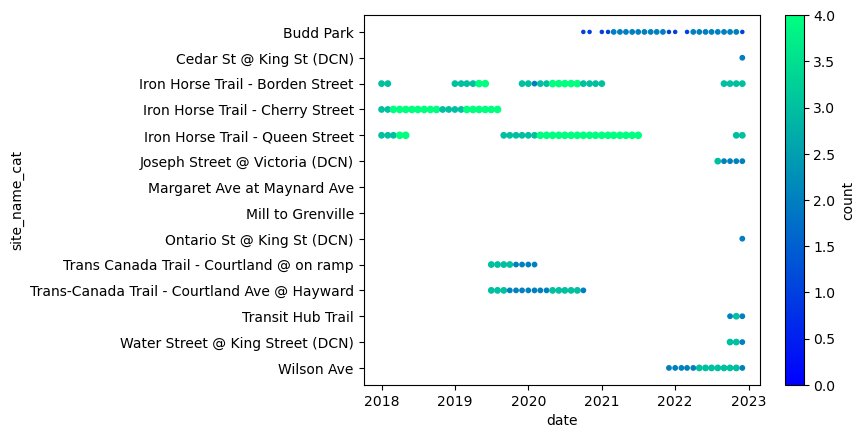

In [61]:
colors = [0, 0x007777, 0x00aa00, 0x00ff00]

df["size"] = df["count"] * 5
df["color"] = df["count"].apply(lambda x: colors[min(int(x), len(colors)-1)])
ax = df.plot.scatter("date", "site_name_cat", s="size", c="count", colormap='winter')
# colormap='RdYlGn'

#plt.colorbar(label="log(count+1)")

ax.set_yticks(site_codes)
ax.set_yticklabels(site_cats)
ax.invert_yaxis()

In [69]:
active = int((df["count"] > 0).value_counts()[True] / len(df) * 100)
print(f"{active=}%")

active=17%


# Users per Site

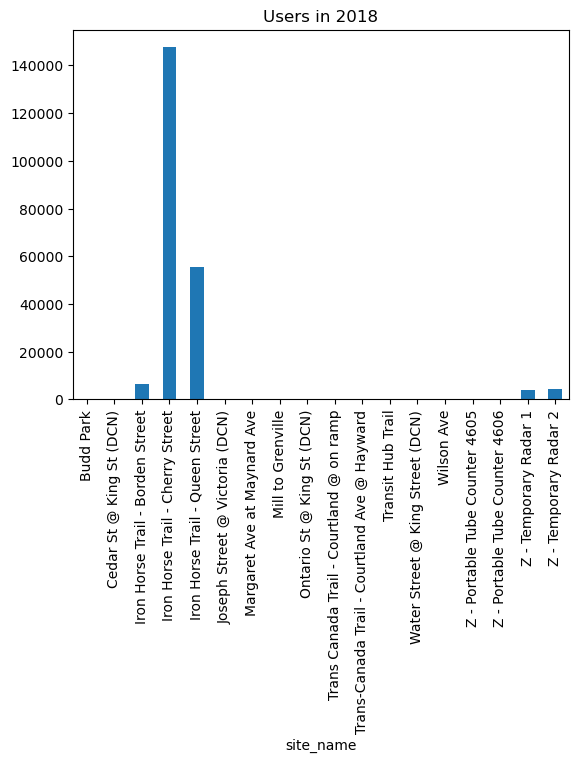

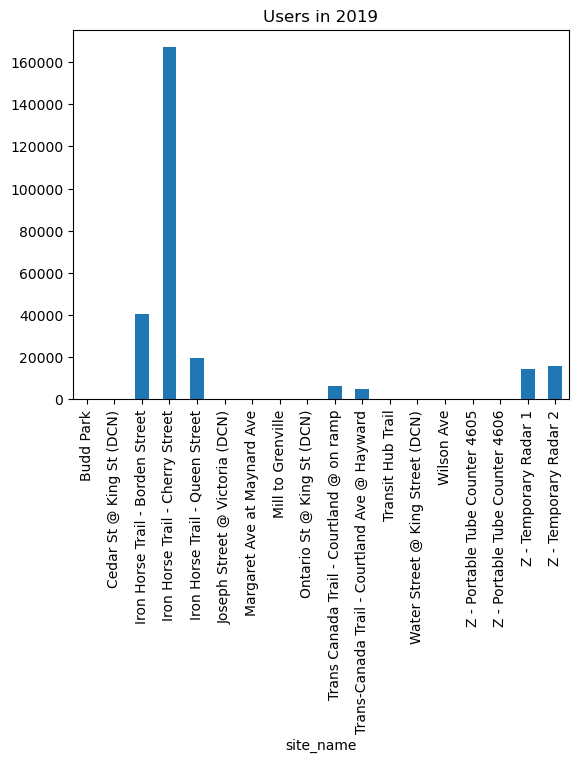

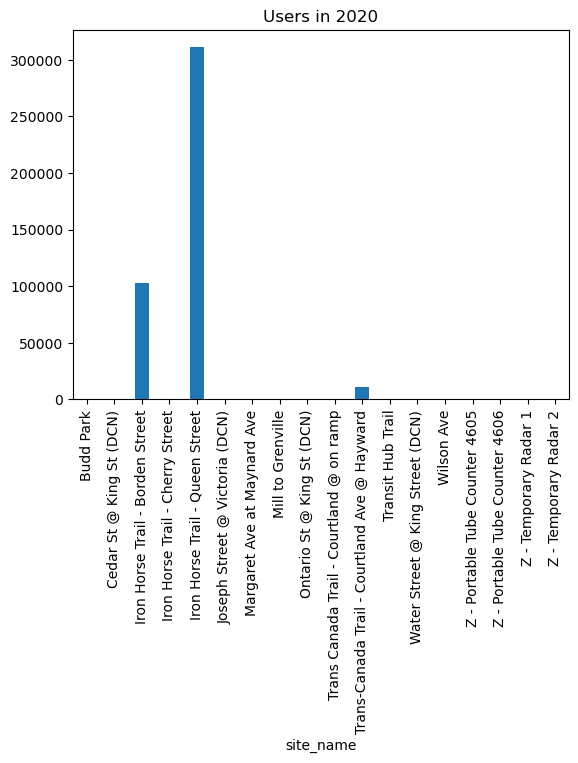

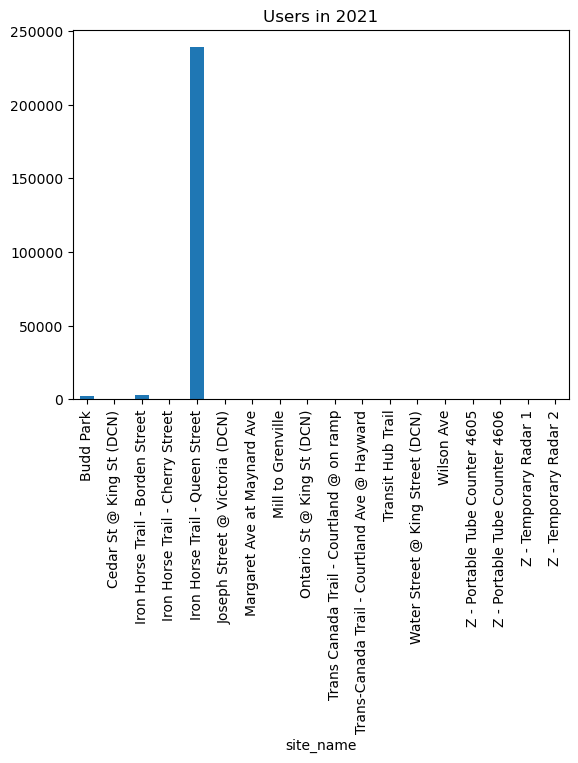

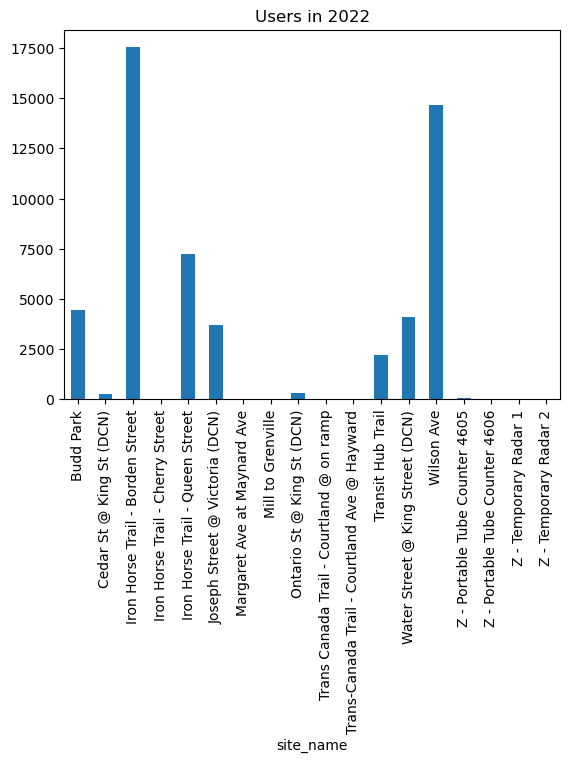

In [55]:
for year in range(hourly_df["year"].min(), hourly_df["year"].max()+1):
    df = hourly_df[hourly_df["year"] == year]
    df = df.groupby("site_name")["count"].sum()
    df.plot.bar(title=f"Users in {year}")
    plt.show()

<Axes: xlabel='site_name'>

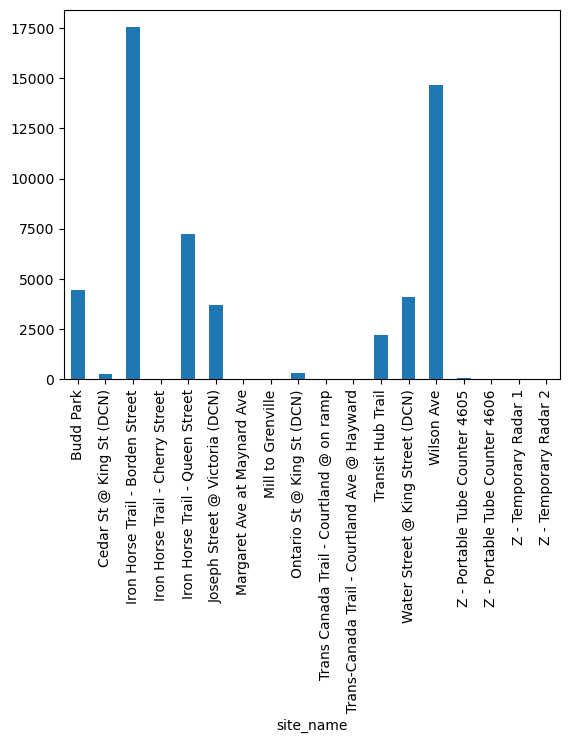

In [47]:
df.plot.bar()
df.plot.bar()

# Users per site over week

In [32]:
df = hourly_df[hourly_df["year"] == 2019]
df = df.groupby(["week", "site_name"])["count"].sum().unstack()
#df

In [33]:
#df.unstack()

<Axes: xlabel='week'>

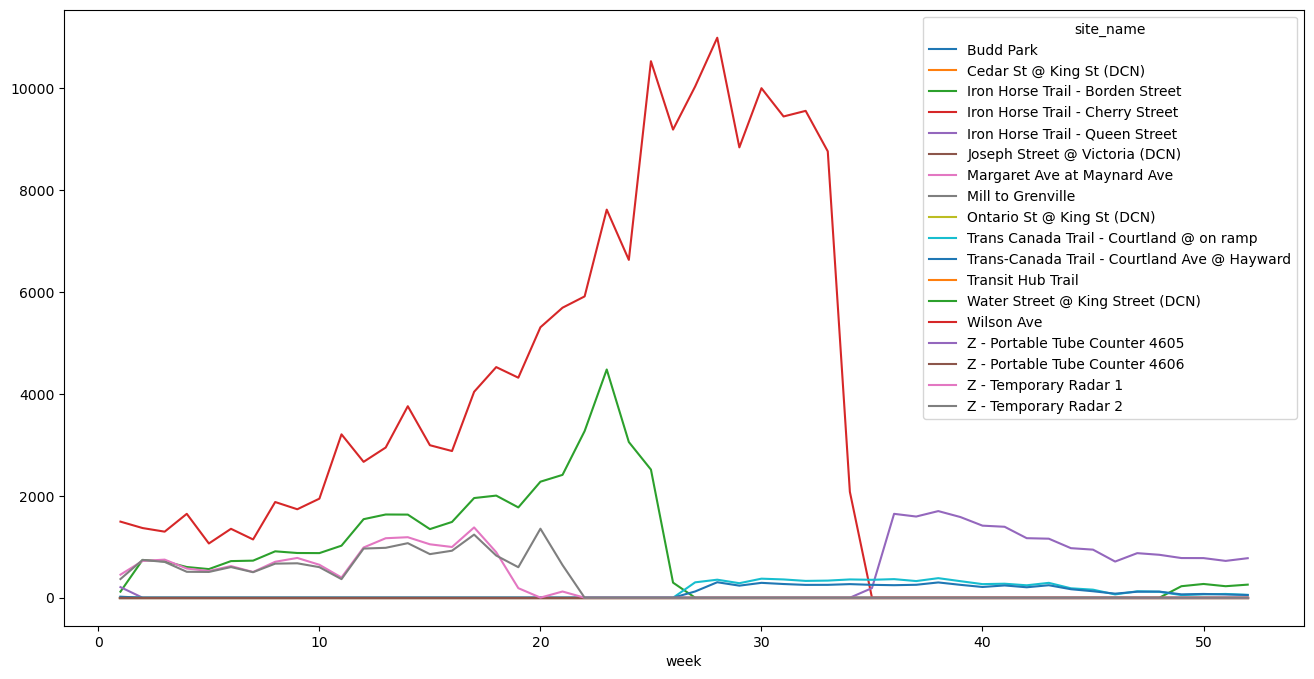

In [40]:
#plt.figure(figsize=(20,3))
df.plot.line(figsize=(16,8))

# Schools?

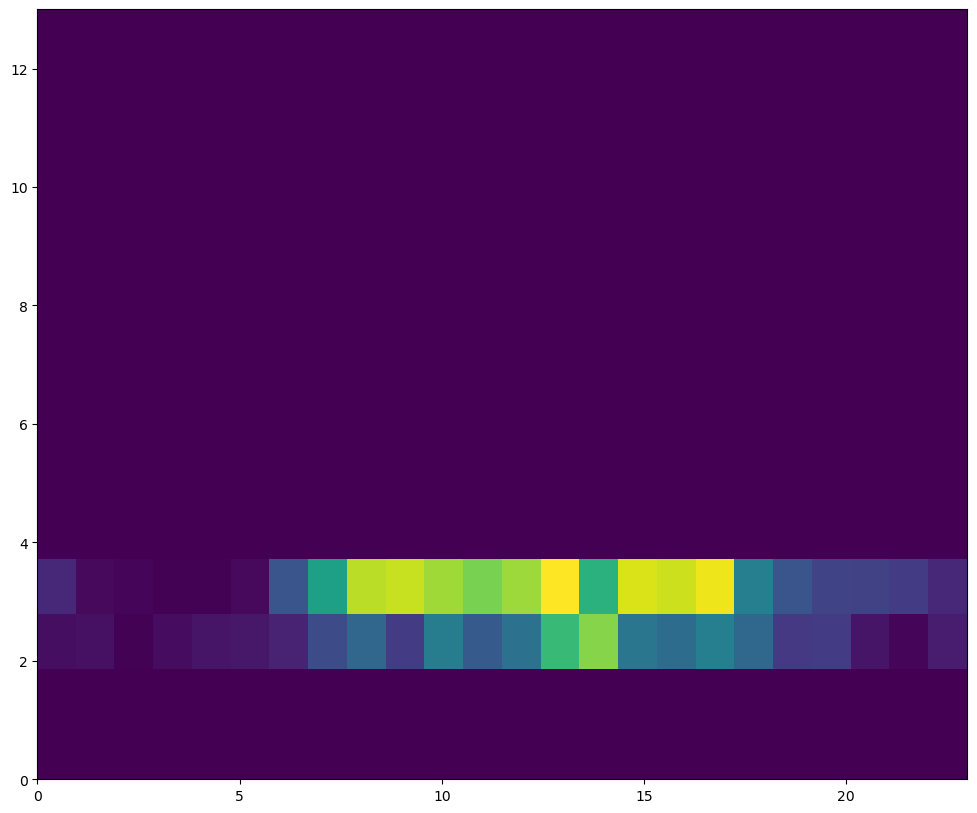

In [70]:
df = hourly_df[hourly_df["year"] == 2019]
df = df[df["week"] == 9]

df = df.groupby(["site_name_cat", "hour"])["count"].sum().reset_index()

hist = calc_histogram_2D(df, "hour", "site_name_cat")
xedges = [0, 23]
yedges = [0, df["site_name_cat"].max()]

plt.figure(figsize=(12,10))
im = plt.imshow(hist.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                    aspect='auto', cmap='viridis')

#plt.savefig(out_dir / 'at_users-week_over_hour_bare.png')

- bar of number of users for each location
- number of nulls -- per location?
- per site numbers each week
- user type